In [1]:
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import load_img, img_to_array, plot_model
from keras import models, optimizers, callbacks
from keras.layers import Input, Layer, Conv2D, Dropout, MaxPool2D, Concatenate, Conv2DTranspose, BatchNormalization

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
dataset_path = '/kaggle/input/semantic-segmentation/'

all_images = glob(dataset_path + "*.jpg")
mask_files = [path.replace(".jpg",".jpg___fuse.png") for path in all_images]

In [3]:
def load_image(path, SIZE=256):
    image = load_img(path)
    image = tfi.resize(image, (SIZE, SIZE))
    image = img_to_array(image)
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image

In [4]:
import tensorflow.image as tfi
from glob import glob
from tqdm import tqdm
import tensorflow as tf
# Load images and masks
def load_data(image_paths, label_paths, SIZE=512):
    images, label_maps = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3)), np.zeros(shape=(len(label_paths), SIZE, SIZE, 3))
    for i, (image_path, label_path) in enumerate(zip(image_paths, label_paths)):
        image, label_map = load_image(image_path, SIZE=SIZE), load_image(label_path, SIZE=SIZE)
        images[i], label_maps[i] = image, label_map
    return images, label_maps

images, label_maps = load_data(all_images, mask_files)

In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test/validation sets
train_images, test_images, train_masks, test_masks = train_test_split(images, label_maps, test_size=0.2, random_state=42)

# Further split the test set into validation and test sets
val_images, test_images, val_masks, test_masks = train_test_split(test_images, test_masks, test_size=0.5, random_state=42)

# Check the shapes of the datasets
print("Train images shape:", train_images.shape)
print("Validation images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (80, 512, 512, 3)
Validation images shape: (10, 512, 512, 3)
Test images shape: (10, 512, 512, 3)


In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose

# Define U-Net architecture
def unet(input_shape=(512, 512, 3)):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom/center
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5), conv2], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv1], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output
    outputs = Conv2D(3, kernel_size=3, padding='same', activation='sigmoid', name="Segmentator")(conv7)  # Adjust the number of channels as needed
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the U-Net model
model = unet()

# Compile the model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [7]:
# Fit the model
model.fit(
    train_images, train_masks,  # Training data
    validation_data=(val_images, val_masks),  # Validation data
    batch_size=16,
    epochs=10  # Adjust the number of epochs as neede
)

Epoch 1/10
5/5 [==============================] - 50s 3s/step - loss: 0.6888 - accuracy: 0.6462 - val_loss: 0.6851 - val_accuracy: 0.7933
Epoch 2/10
5/5 [==============================] - 6s 1s/step - loss: 0.6798 - accuracy: 0.8189 - val_loss: 0.7539 - val_accuracy: 0.7653
Epoch 3/10
5/5 [==============================] - 6s 1s/step - loss: 0.6893 - accuracy: 0.5952 - val_loss: 0.7114 - val_accuracy: 0.5260
Epoch 4/10
5/5 [==============================] - 6s 1s/step - loss: 0.6823 - accuracy: 0.6736 - val_loss: 0.7041 - val_accuracy: 0.5644
Epoch 5/10
5/5 [==============================] - 6s 1s/step - loss: 0.6810 - accuracy: 0.6026 - val_loss: 0.7043 - val_accuracy: 0.6581
Epoch 6/10
5/5 [==============================] - 6s 1s/step - loss: 0.7130 - accuracy: 0.5946 - val_loss: 0.7553 - val_accuracy: 0.5445
Epoch 7/10
5/5 [==============================] - 6s 1s/step - loss: 0.6914 - accuracy: 0.7206 - val_loss: 0.7792 - val_accuracy: 0.6649
Epoch 8/10
5/5 [========================

1/1 [==============================] - 4s 4s/step


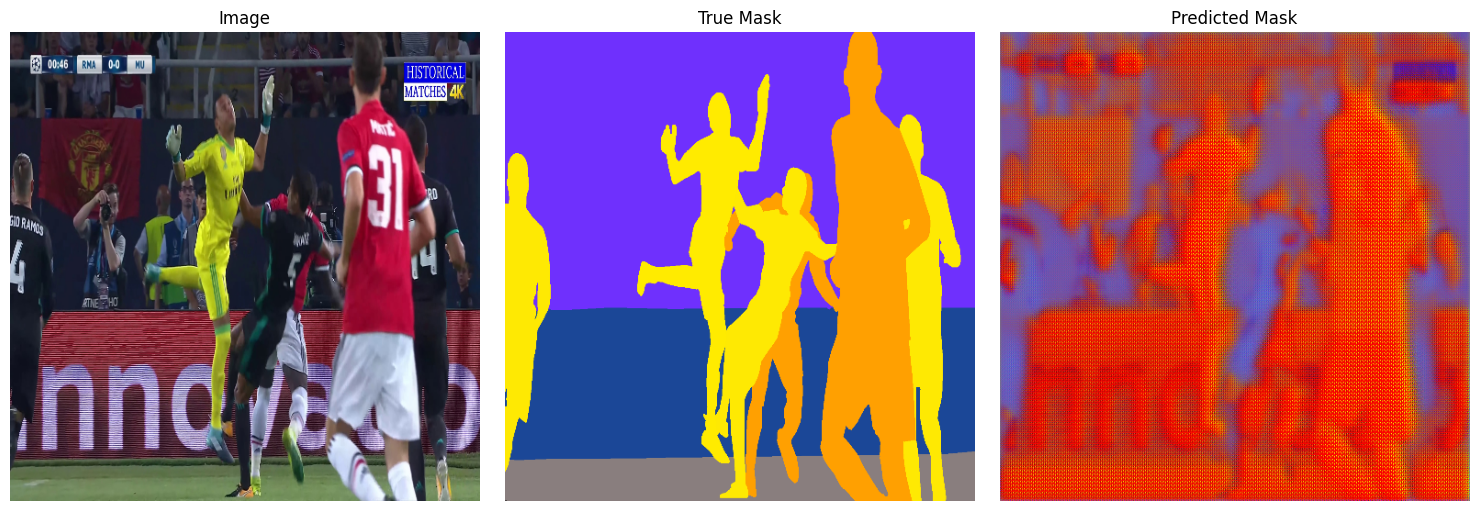

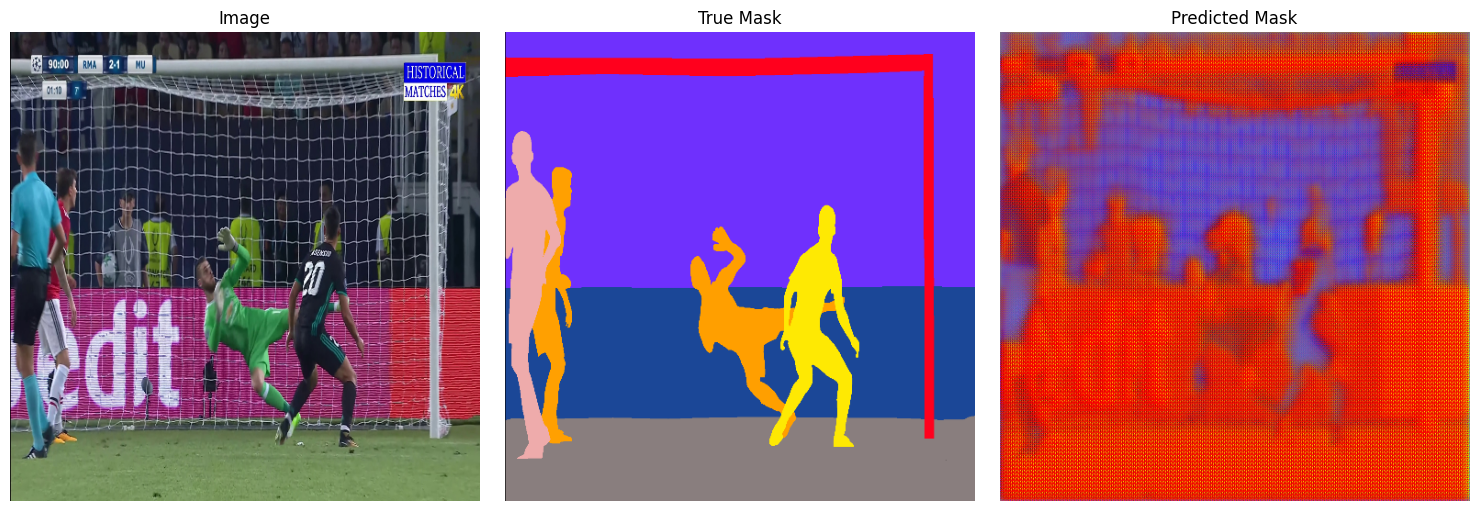

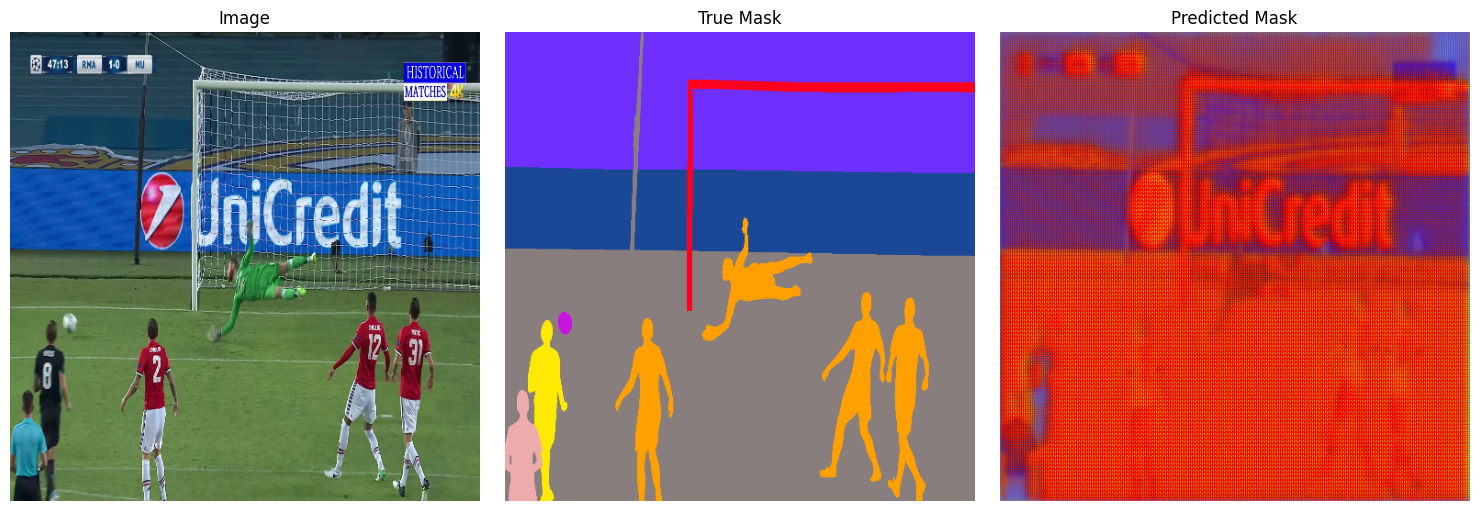

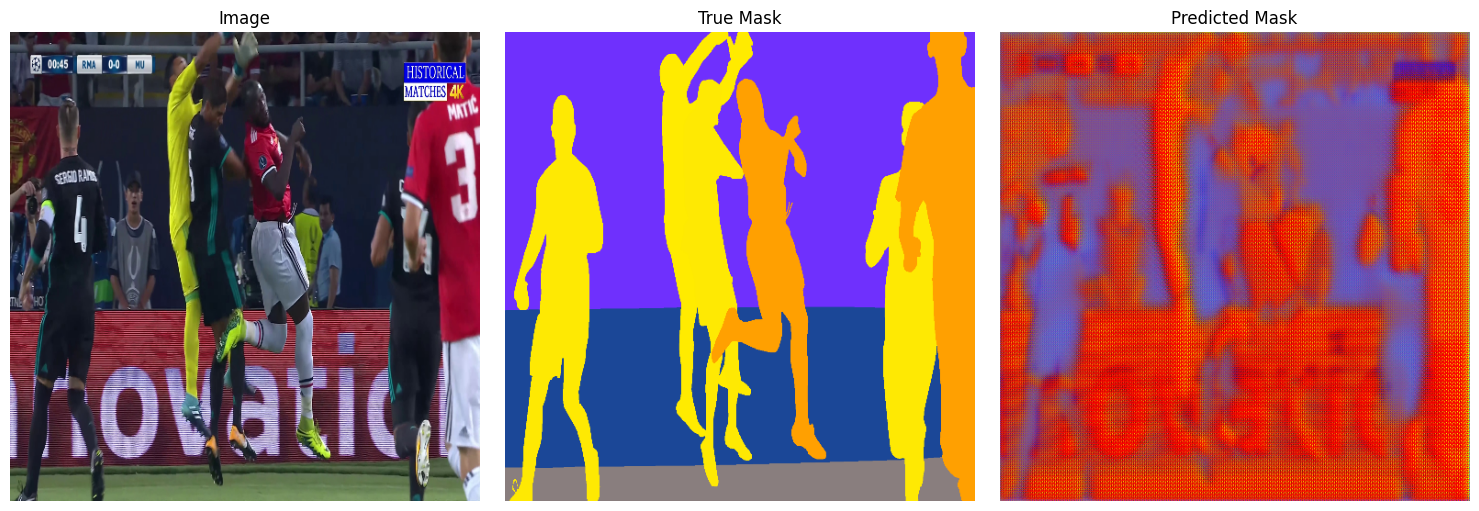

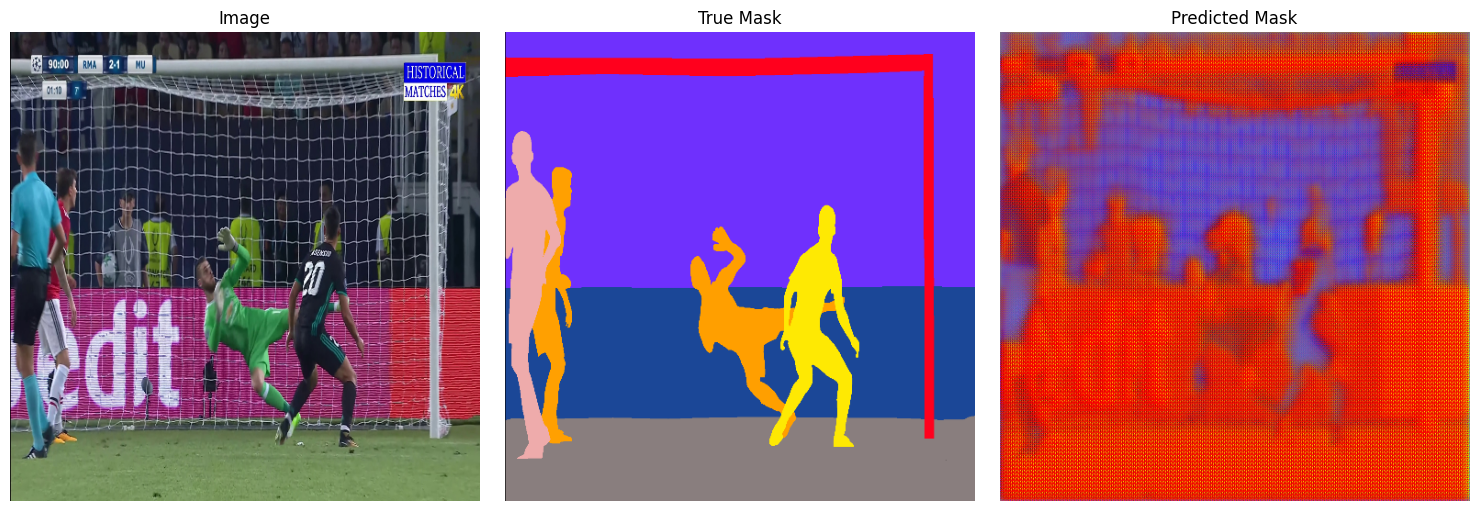

In [8]:
import matplotlib.pyplot as plt

# Assuming you have loaded test images and masks as test_images and test_label_maps

# Choose a few random indices from your test dataset
num_samples_to_display = 5
indices = np.random.randint(0, len(test_images), num_samples_to_display)

# Predict masks for the selected images
predicted_masks = model.predict(test_images[indices])

# Plotting the images, true masks, and predicted masks
for i in range(num_samples_to_display):
    plt.figure(figsize=(15, 5))

    # Plotting the image
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[indices[i]])
    plt.title("Image")
    plt.axis('off')

    # Plotting the true mask
    plt.subplot(1, 3, 2)
    plt.imshow(test_masks[indices[i]])
    plt.title("True Mask")
    plt.axis('off')

    # Plotting the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[i])
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()